In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [2]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
T = pd.read_csv('/home/sa42/data/glac/T_models/T.csv')
glathida = T
glathida = glathida[[
    'LAT',
    'LON',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS',
    'MAXIMUM_THICKNESS',
]]

glathida = glathida.dropna()
glathida

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS,MAXIMUM_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0,107.0
33,58.380000,-134.360000,11.700,0.0,66.0,200.0
44,38.767000,72.283000,824.000,0.0,175.0,900.0
47,45.236450,80.781660,3.200,0.0,49.0,116.0
48,45.235130,80.808350,3.400,0.0,49.0,139.0
...,...,...,...,...,...,...
616,61.730000,5.660000,3.280,9.0,68.0,163.0
620,78.245480,16.064380,2.100,13.0,32.0,106.0
628,43.043653,77.080587,2.610,20.0,47.0,103.0
632,77.971400,14.069100,6.737,6.0,65.0,191.0


### separate out features - what will be trained to predict desired attribute

In [3]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('MAXIMUM_THICKNESS')
test_labels = test_features.pop('MAXIMUM_THICKNESS')

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,48.447838,18.725174
LON,16.513162,53.412789
AREA,21.430462,115.236640
MEAN_SLOPE,15.960784,9.028756
MEAN_THICKNESS,50.313725,42.809574


# Step 2: Setup the Model

### Establish normalization layers

In [4]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

  0%|          | 0/5 [00:00<?, ?it/s]2022-03-21 13:44:11.577637: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-21 13:44:11.577688: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-21 13:44:11.578110: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
 80%|████████  | 4/5 [00:00<00:00,  6.58it/s]

100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


In [5]:
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [6]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 5/5 [01:49<00:00, 21.98s/it]

CPU times: user 2min 28s, sys: 59.8 s, total: 3min 27s
Wall time: 1min 49s


ValueError: num must be 1 <= num <= 4, not 5

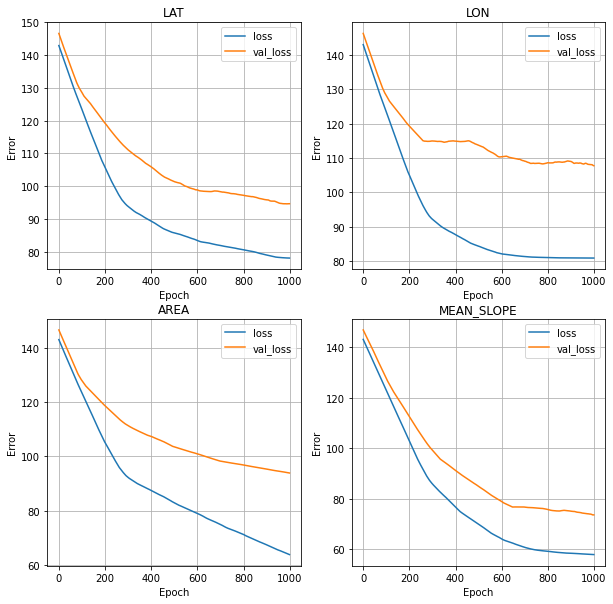

In [28]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
#     mpl_style("dark")
    ax = plt.subplot(2,2,i+1)
    plt.subplot(2,2,i+1)
    gl.plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T_linear_loss.eps")

# Linear regression with multiple inputs

In [8]:
linear_model = gl.build_linear_model(normalizer['ALL'])

linear_history['MULTI'] = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

linear_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

<function glacierml.plot_loss(history)>

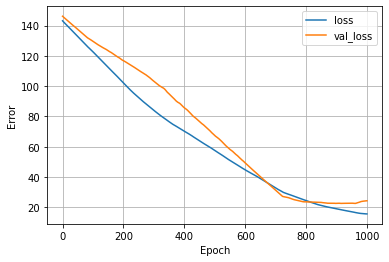

In [21]:
gl.plot_loss(linear_history['MULTI'])
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T_linear_multi_loss.eps")

# DNN regression

In [10]:
# test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

In [12]:
# def plot_single_model_variable(x, y,feature_name):
#     plt.scatter(feature_name, train_labels, label='Data')
#     plt.plot(x, y, color='k', label='Predictions')
#     plt.xlabel(feature_name)
#     plt.ylabel('Avg Thickness (m)')
# #     plt.xlim((0,20))
#     plt.legend()

In [35]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(4,4,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     plot_single_model_variable(x,y,train_features[variable_name])

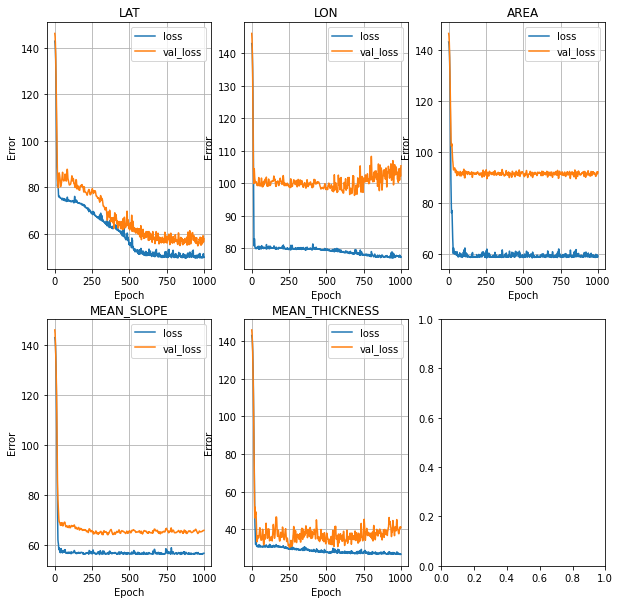

In [33]:
fig,ax=plt.subplots(2,3,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,3,i+1)
    gl.plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T_dnn_loss.eps")

# Full model

In [16]:
%%time
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])
dnn_history['MULTI'] = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

dnn_results['MULTI'] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

CPU times: user 40.6 s, sys: 22.4 s, total: 1min 2s
Wall time: 27.7 s


<function glacierml.plot_loss(history)>

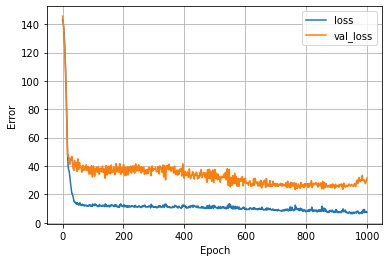

In [17]:
gl.plot_loss(dnn_history['MULTI'])
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T_dnn_multi_loss.png")

(0.0, 200.0)

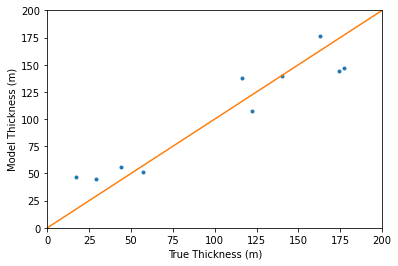

In [18]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T_Prethicktions.EPS")

# Collect Results

In [19]:
dfs = pd.DataFrame()
for variable_name in list(dnn_history):    
    df1 = pd.DataFrame(dnn_history[variable_name].history)
    df2 = pd.DataFrame(linear_history[variable_name].history)
    df1 = df1.loc[[df1.last_valid_index()]]
    df2 = df2.loc[[df2.last_valid_index()]]
    df1['Architecture'] = 'DNN'
    df2['Architecture'] = 'Linear'
    df1.insert(0, 'Variable', [variable_name])
    df2.insert(0, 'Variable', [variable_name])
    df = pd.concat([df1,df2])
    dfs = dfs.append(df)
    
df = dfs[[
    'Architecture',
    'Variable',
    'loss',
    'val_loss'
]]
df = df.sort_values(by=['Architecture','Variable'], ascending=[False,False])
print(df.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Architecture &       Variable &      loss &   val\_loss \\
\midrule
      Linear &          MULTI & 15.581479 &  24.252556 \\
      Linear & MEAN\_THICKNESS & 30.370996 &  24.141516 \\
      Linear &     MEAN\_SLOPE & 57.985485 &  73.658806 \\
      Linear &            LON & 80.860062 & 107.761330 \\
      Linear &            LAT & 78.016884 &  94.622223 \\
      Linear &           AREA & 63.796082 &  93.851715 \\
         DNN &          MULTI &  7.469008 &  31.500032 \\
         DNN & MEAN\_THICKNESS & 26.730667 &  41.057095 \\
         DNN &     MEAN\_SLOPE & 56.827026 &  65.980057 \\
         DNN &            LON & 77.322960 & 105.392181 \\
         DNN &            LAT & 49.933784 &  57.880417 \\
         DNN &           AREA & 58.870689 &  92.135521 \\
\bottomrule
\end{tabular}

